# Training of the Neural Network

Import all libraries

In [1]:
import numpy as np
from tqdm import tqdm
# Matplotlib
import matplotlib.pyplot as plt
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as tt
from torchvision.datasets import EMNIST
from torchvision.utils import make_grid

c:\Users\Patrick\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Empty the CUDA cache to be sure that the cache is not blocking the graphic memory.

In [2]:
torch.cuda.empty_cache()

Check if CUDA is available otherwise it will use the CPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Download the EMNIST dataset

In [4]:
train_dataset = EMNIST(root="data", download=True, train=True, split="balanced", 
                        transform=torchvision.transforms.Compose([
                            lambda img: tt.functional.rotate(img, -90),
                            lambda img: tt.functional.hflip(img),
                            tt.ToTensor(),
                            tt.Normalize((0.5), (0.5))
                        ]))
test_dataset = EMNIST(root="data", download=True, train=True, split="balanced", 
                        transform=torchvision.transforms.Compose([
                            lambda img: tt.functional.rotate(img, -90),
                            lambda img: tt.functional.hflip(img),
                            tt.ToTensor(),
                            tt.Normalize((0.5), (0.5))
                        ]))

Print some informations

In [5]:
print("Length of training dataset: ",len(train_dataset))
print("Length of test dataset: ",len(test_dataset))

Length of training dataset:  112800
Length of test dataset:  112800


In [6]:
classes = train_dataset.classes
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't']


Create a DataLoader objects with the given batch_size

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

Example of a Batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


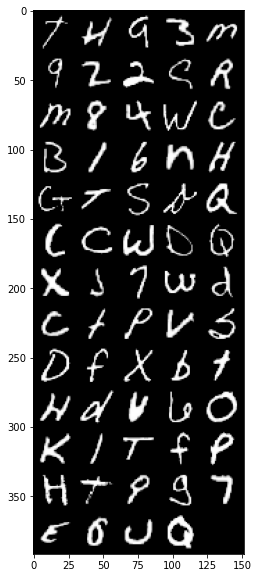

In [8]:
for img, label in train_dataloader:
    plt.figure(figsize=(20, 10))
    plt.imshow(make_grid(img, nrow=5).permute(1, 2, 0), cmap='binary')
    break

The Neural Network Class

In [9]:
class Net(nn.Module):
    def __init__(self, output_size, device):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 36, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
        ).to(device)
        self.conv2 = nn.Sequential(
            nn.Conv2d(36, 72, kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
        ).to(device) # New size 5x5
        self.out = nn.Sequential(
            nn.Linear(72*5*5, 200),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.Linear(200, output_size)
        ).to(device)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        out = x.view(x.shape[0], -1)
        return self.out(out)


Create an object of the class

In [10]:
model = Net(output_size=len(classes), device=device)

Choose the Adam optimizer and the CrossEntropyLoss as Loss function.

In [11]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss().to(device)

Number of epochs

In [12]:
epochs = 75

In [13]:
losses = []
overall_loss = []

Move the model to the selected device

In [14]:
model.to(device)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 36, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(36, 72, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1800, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=200, out_features=47, bias=True)
  )
)

## Training

In [15]:
for epoch in range(epochs):
    model.train()
    batch_loss = []
    for i, (batch, label) in enumerate(tqdm(train_dataloader)):
        batch, label = batch.to(device), label.to(device)
        output = model(batch)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # print(f'Batch {i}: Loss: {loss.item()}')
        batch_loss.append(loss.item())
    

    losses.append(np.mean(np.array(batch_loss)))
    overall_loss.append(batch_loss)
    print(f'> Epoch {epoch}: Loss {np.mean(np.array(batch_loss))}')

100%|██████████| 1763/1763 [00:40<00:00, 43.11it/s]


> Epoch 0: Loss 0.713186023540275


100%|██████████| 1763/1763 [00:37<00:00, 46.84it/s]


> Epoch 1: Loss 0.42291980141259294


100%|██████████| 1763/1763 [00:38<00:00, 45.63it/s]


> Epoch 2: Loss 0.37479328974379916


100%|██████████| 1763/1763 [00:38<00:00, 46.06it/s]


> Epoch 3: Loss 0.34061101332551974


100%|██████████| 1763/1763 [00:37<00:00, 47.05it/s]


> Epoch 4: Loss 0.3166492226545742


100%|██████████| 1763/1763 [00:36<00:00, 48.28it/s]


> Epoch 5: Loss 0.29595465695256207


100%|██████████| 1763/1763 [00:36<00:00, 48.88it/s]


> Epoch 6: Loss 0.28256492191208266


100%|██████████| 1763/1763 [00:37<00:00, 47.64it/s]


> Epoch 7: Loss 0.26564737022666857


100%|██████████| 1763/1763 [00:36<00:00, 48.41it/s]


> Epoch 8: Loss 0.2547844127729172


100%|██████████| 1763/1763 [00:36<00:00, 48.88it/s]


> Epoch 9: Loss 0.24298618538215358


100%|██████████| 1763/1763 [00:36<00:00, 48.49it/s]


> Epoch 10: Loss 0.2325603282644339


100%|██████████| 1763/1763 [00:37<00:00, 47.39it/s]


> Epoch 11: Loss 0.22241154862900586


100%|██████████| 1763/1763 [00:36<00:00, 48.31it/s]


> Epoch 12: Loss 0.21686749475555397


100%|██████████| 1763/1763 [00:36<00:00, 48.18it/s]


> Epoch 13: Loss 0.2079694670515681


100%|██████████| 1763/1763 [00:36<00:00, 48.10it/s]


> Epoch 14: Loss 0.20338499244520156


100%|██████████| 1763/1763 [00:36<00:00, 48.56it/s]


> Epoch 15: Loss 0.19392184305025378


100%|██████████| 1763/1763 [00:35<00:00, 49.24it/s]


> Epoch 16: Loss 0.19080280855940407


100%|██████████| 1763/1763 [00:35<00:00, 50.02it/s]


> Epoch 17: Loss 0.18601844478155563


100%|██████████| 1763/1763 [00:36<00:00, 48.12it/s]


> Epoch 18: Loss 0.1767708348026853


100%|██████████| 1763/1763 [00:38<00:00, 45.34it/s]


> Epoch 19: Loss 0.1761706825578189


100%|██████████| 1763/1763 [00:43<00:00, 40.39it/s]


> Epoch 20: Loss 0.17055030563614854


100%|██████████| 1763/1763 [00:48<00:00, 36.22it/s]


> Epoch 21: Loss 0.16684945885639296


100%|██████████| 1763/1763 [00:41<00:00, 42.71it/s]


> Epoch 22: Loss 0.1637255629261515


100%|██████████| 1763/1763 [00:39<00:00, 44.22it/s]


> Epoch 23: Loss 0.1619298950849831


100%|██████████| 1763/1763 [00:39<00:00, 44.96it/s]


> Epoch 24: Loss 0.15501584855166606


100%|██████████| 1763/1763 [00:37<00:00, 46.90it/s]


> Epoch 25: Loss 0.15440019654237913


100%|██████████| 1763/1763 [00:39<00:00, 44.98it/s]


> Epoch 26: Loss 0.15232004029850643


100%|██████████| 1763/1763 [00:42<00:00, 41.34it/s]


> Epoch 27: Loss 0.14884916414209323


100%|██████████| 1763/1763 [00:42<00:00, 41.73it/s]


> Epoch 28: Loss 0.14500237173668648


100%|██████████| 1763/1763 [00:44<00:00, 39.30it/s]


> Epoch 29: Loss 0.145307453979447


100%|██████████| 1763/1763 [00:41<00:00, 42.59it/s]


> Epoch 30: Loss 0.14076003191492906


100%|██████████| 1763/1763 [00:38<00:00, 45.35it/s]


> Epoch 31: Loss 0.14037481219926665


100%|██████████| 1763/1763 [00:37<00:00, 47.56it/s]


> Epoch 32: Loss 0.13690594024480793


100%|██████████| 1763/1763 [00:36<00:00, 48.28it/s]


> Epoch 33: Loss 0.13779905218878255


100%|██████████| 1763/1763 [00:37<00:00, 47.42it/s]


> Epoch 34: Loss 0.13357095624533097


100%|██████████| 1763/1763 [00:38<00:00, 46.20it/s]


> Epoch 35: Loss 0.13462563025354662


100%|██████████| 1763/1763 [00:43<00:00, 40.16it/s]


> Epoch 36: Loss 0.1320566158011129


100%|██████████| 1763/1763 [00:45<00:00, 38.91it/s]


> Epoch 37: Loss 0.13430117395132257


100%|██████████| 1763/1763 [00:42<00:00, 41.35it/s]


> Epoch 38: Loss 0.12951669210311337


100%|██████████| 1763/1763 [00:37<00:00, 46.52it/s]


> Epoch 39: Loss 0.12730296535372007


100%|██████████| 1763/1763 [00:42<00:00, 41.23it/s]


> Epoch 40: Loss 0.1262695414193241


100%|██████████| 1763/1763 [00:44<00:00, 39.98it/s]


> Epoch 41: Loss 0.12367093490173335


100%|██████████| 1763/1763 [00:40<00:00, 43.37it/s]


> Epoch 42: Loss 0.1247250491957129


100%|██████████| 1763/1763 [00:37<00:00, 47.29it/s]


> Epoch 43: Loss 0.12222135708293858


100%|██████████| 1763/1763 [00:38<00:00, 46.19it/s]


> Epoch 44: Loss 0.12353786180916829


100%|██████████| 1763/1763 [00:37<00:00, 46.49it/s]


> Epoch 45: Loss 0.12131294952805873


100%|██████████| 1763/1763 [00:37<00:00, 46.40it/s]


> Epoch 46: Loss 0.12064854894572963


100%|██████████| 1763/1763 [00:40<00:00, 43.94it/s]


> Epoch 47: Loss 0.11762044901557592


100%|██████████| 1763/1763 [00:39<00:00, 45.17it/s]


> Epoch 48: Loss 0.11766513631538073


100%|██████████| 1763/1763 [00:38<00:00, 45.56it/s]


> Epoch 49: Loss 0.11758970699214413


100%|██████████| 1763/1763 [00:38<00:00, 45.30it/s]


> Epoch 50: Loss 0.11836712229289051


100%|██████████| 1763/1763 [00:47<00:00, 37.32it/s]


> Epoch 51: Loss 0.1153747379374112


100%|██████████| 1763/1763 [00:41<00:00, 42.18it/s]


> Epoch 52: Loss 0.11402504595595618


100%|██████████| 1763/1763 [00:41<00:00, 42.83it/s]


> Epoch 53: Loss 0.11446439952156927


100%|██████████| 1763/1763 [00:42<00:00, 41.08it/s]


> Epoch 54: Loss 0.11210002428368664


100%|██████████| 1763/1763 [00:38<00:00, 45.61it/s]


> Epoch 55: Loss 0.11377079324980102


100%|██████████| 1763/1763 [00:38<00:00, 45.89it/s]


> Epoch 56: Loss 0.11104286808527951


100%|██████████| 1763/1763 [00:42<00:00, 41.31it/s]


> Epoch 57: Loss 0.11321076736875275


100%|██████████| 1763/1763 [00:42<00:00, 41.97it/s]


> Epoch 58: Loss 0.110509033421064


100%|██████████| 1763/1763 [00:38<00:00, 45.56it/s]


> Epoch 59: Loss 0.1102864743087951


100%|██████████| 1763/1763 [00:47<00:00, 37.32it/s]


> Epoch 60: Loss 0.10917861742124392


100%|██████████| 1763/1763 [00:40<00:00, 43.12it/s]


> Epoch 61: Loss 0.10774686341942566


100%|██████████| 1763/1763 [00:41<00:00, 42.54it/s]


> Epoch 62: Loss 0.1096503639842531


100%|██████████| 1763/1763 [00:42<00:00, 41.22it/s]


> Epoch 63: Loss 0.10531977261073246


100%|██████████| 1763/1763 [00:38<00:00, 45.46it/s]


> Epoch 64: Loss 0.1075339378512127


100%|██████████| 1763/1763 [00:39<00:00, 44.67it/s]


> Epoch 65: Loss 0.10675644020164851


100%|██████████| 1763/1763 [00:40<00:00, 43.06it/s]


> Epoch 66: Loss 0.10772269588730853


100%|██████████| 1763/1763 [00:41<00:00, 42.83it/s]


> Epoch 67: Loss 0.10532258674108819


100%|██████████| 1763/1763 [00:38<00:00, 45.61it/s]


> Epoch 68: Loss 0.10639064981862564


100%|██████████| 1763/1763 [00:38<00:00, 46.05it/s]


> Epoch 69: Loss 0.10593422820701269


100%|██████████| 1763/1763 [00:38<00:00, 45.36it/s]


> Epoch 70: Loss 0.10462059970582006


100%|██████████| 1763/1763 [00:42<00:00, 41.89it/s]


> Epoch 71: Loss 0.10466784723388307


100%|██████████| 1763/1763 [00:38<00:00, 45.91it/s]


> Epoch 72: Loss 0.10487557827562127


100%|██████████| 1763/1763 [00:38<00:00, 45.51it/s]


> Epoch 73: Loss 0.09922892938410811


100%|██████████| 1763/1763 [00:38<00:00, 46.35it/s]

> Epoch 74: Loss 0.10304316921371985


Plot the losses

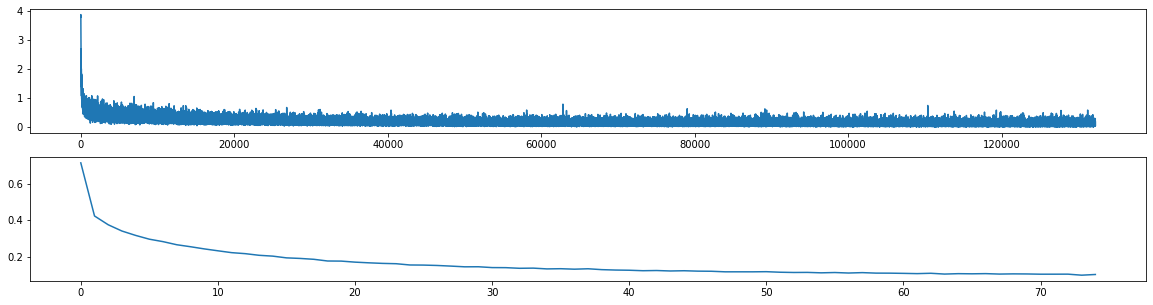

In [16]:
fig, ax = plt.subplots(nrows=2, figsize=(20, 5))
ax[0].plot(np.array(overall_loss).reshape(-1))
ax[1].plot(losses)

Compute the accurancy with the test data

In [17]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    # fig, ax = plt.subplots(nrows=20, figsize=(20,20))
    for i, (data, label) in enumerate(tqdm(test_dataset)):
        # ax[i].imshow(data.cpu().reshape(28, 28), cmap="binary")
        output = model(data.reshape(1, 1, 28, 28).to(device))
        output = output.cpu().numpy()
        output = np.argmax(output)
        # print(f"{classes[output]}:{classes[label]}")
        total += 1
        if output == label:
            correct += 1
    print(f'{(correct/total)*100}%')

100%|██████████| 112800/112800 [02:38<00:00, 711.80it/s]

98.3936170212766%


Save the model

In [18]:
model.to('cpu')
torch.save(model.state_dict(), 'model.pth')